Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [25]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [35]:
from IPython.display import Image
train_folders
c1 = -1
c2= -1
for folder in train_folders:
    path = "/Users/miladmahdian/DataScience/"+folder
    for root, dirnames, filenames in os.walk(path):
                for filename in filenames:
                    c2 +=1
                    if c2 % 50000 == 0:
                        print(os.path.join(root, filename))
                        p = os.path.join(root, filename)
                        display(Image(filename=p,format='png'))
                        


/Users/miladmahdian/DataScience/notMNIST_large/A
/Users/miladmahdian/DataScience/notMNIST_large/A/a29ydW5pc2hpLnR0Zg==.png


/Users/miladmahdian/DataScience/notMNIST_large/A/VlRDR29ibGluSGFuZFNDLnR0Zg==.png


/Users/miladmahdian/DataScience/notMNIST_large/B
/Users/miladmahdian/DataScience/notMNIST_large/B/V2lzaGZ1bFdhdmVzLnR0Zg==.png


/Users/miladmahdian/DataScience/notMNIST_large/C
/Users/miladmahdian/DataScience/notMNIST_large/C/Um9idXN0IElDRyBJdGFsaWMudHRm.png


/Users/miladmahdian/DataScience/notMNIST_large/D
/Users/miladmahdian/DataScience/notMNIST_large/D/UDIySG9wcGVyLVNrZXRjaGVzLm90Zg==.png


/Users/miladmahdian/DataScience/notMNIST_large/E
/Users/miladmahdian/DataScience/notMNIST_large/E/U2ltaWFuRGlzcGxheS1Hb3JpbGxhTGlncy5wZmI=.png


/Users/miladmahdian/DataScience/notMNIST_large/F
/Users/miladmahdian/DataScience/notMNIST_large/F/TWlyb1JlZ3VsYXIub3Rm.png


/Users/miladmahdian/DataScience/notMNIST_large/G
/Users/miladmahdian/DataScience/notMNIST_large/G/TmV3cyBTZXJpZiBJVEFMSUMudHRm.png


/Users/miladmahdian/DataScience/notMNIST_large/H
/Users/miladmahdian/DataScience/notMNIST_large/H/TFRVbml2ZXJzLUNvbXBNZWRpdW0ub3Rm.png


/Users/miladmahdian/DataScience/notMNIST_large/I
/Users/miladmahdian/DataScience/notMNIST_large/I/SVRDIFN5bWJvbCBNZWRpdW0gSXRhbGljLnBmYg==.png


/Users/miladmahdian/DataScience/notMNIST_large/J
/Users/miladmahdian/DataScience/notMNIST_large/J/S3JhenkgTmlnaHRzLnR0Zg==.png


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [36]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32) # 3D array
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth #normalize data
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))# str makes the tuple to string
      dataset[num_images, :, :] = image_data #save in a 3D array
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images)) # use tuple for multiple input to be printed
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.454491
Pickling notMNIST_large/C.pic

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.



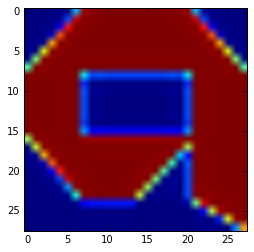

In [42]:
import matplotlib.pyplot as plt
filename = "/Users/miladmahdian/DataScience/"+train_folders[0]+".pickle"
with open(filename, 'rb') as f:
          dataset = pickle.load(f)
          plt.figure()
          plt.imshow(dataset[0,:,:])

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [109]:
for folder in train_folders:
    filename = folder+".pickle" # since the notebook is in the"/Users/miladmahdian/DataScience/", no need for it.
    with open(filename, 'rb') as f:
          dataset = pickle.load(f)
          print("For %s, the size of the dataset is %d" % (folder,dataset.shape[0]) )

For notMNIST_large/A, the size of the dataset is 52909
For notMNIST_large/B, the size of the dataset is 52911
For notMNIST_large/C, the size of the dataset is 52912
For notMNIST_large/D, the size of the dataset is 52911
For notMNIST_large/E, the size of the dataset is 52912
For notMNIST_large/F, the size of the dataset is 52912
For notMNIST_large/G, the size of the dataset is 52912
For notMNIST_large/H, the size of the dataset is 52912
For notMNIST_large/I, the size of the dataset is 52912
For notMNIST_large/J, the size of the dataset is 52911


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [45]:
def make_arrays(nb_rows, img_size):
  if nb_rows: # if non-zero
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels
#pickle_files: the list of pickle filenames: e.g.: notMNIST/A.pickle
def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class # the total subset (train+valid) which we are using from the per-letter dataset
  for label, pickle_file in enumerate(pickle_files):  #label is the index of the pickle_file     
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label # label is a scalar
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000 # total training set is 50k*10= 500k
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [46]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0]) # creates a permutation of index 0 to number of images-1 
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Finally, let's save the data for later reuse:

In [47]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [48]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [150]:
def sanitize(train_set,train_labels,test_set):
    counter = 0
    indices = set()
    for i in xrange(train_set.shape[0]):
        for j in xrange(test_set.shape[0]):
            if np.array_equal(train_set[i,:,:],test_set[j,:,:]) and i not in indices:
                counter+=1
                indices.add(i) #only save the indices in the train_set
    indices = list(indices)            
    c = np.delete(train_set,indices,axis=0)
    print("The number of overlaps is %d size of new set %d"%(counter,c.shape[0]))
    return counter,c , np.delete(train_labels,indices,axis=0)


    
    
    

In [152]:
def make_arrays(nb_rows, img_size):
  if nb_rows: # if non-zero
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels
#pickle_files: the list of pickle filenames: e.g.: notMNIST/A.pickle
def merge_datasets_with_sanitization(pickle_files, train_size,test_datasets, test_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  train_dataset_san, train_labels_san = make_arrays(train_size, image_size)


  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
  tesize_per_class = test_size // num_classes

  overlap = 0
  start_v, start_t,start_te = 0, 0, 0
  end_v, end_t, end_te = vsize_per_class, tsize_per_class, tesize_per_class
  end_l = vsize_per_class+tsize_per_class # the total subset (train+valid) which we are using from the per-letter dataset
  for label, pickle_file in enumerate(pickle_files):  #label is the index of the pickle_file     
    try:
      with open(pickle_file, 'rb') as f, open(test_datasets[label],'rb') as g:
        #with open(test_datasets[label],'rb') as g:
            letter_set = pickle.load(f)
            letter_test_set = pickle.load(g)
            # let's shuffle the letters to have random validation and training set
            np.random.shuffle(letter_set)
            np.random.shuffle(letter_test_set)
            if valid_dataset is not None:
              valid_letter = letter_set[:vsize_per_class, :, :]
              valid_dataset[start_v:end_v, :, :] = valid_letter
              valid_labels[start_v:end_v] = label # label is a scalar
              start_v += vsize_per_class
              end_v += vsize_per_class
                    
            train_letter = letter_set[vsize_per_class:end_l, :, :]
            train_dataset[start_t:end_t, :, :] = train_letter
            train_labels[start_t:end_t] = label

            test_letter = letter_test_set[:tesize_per_class, :, :]
            test_dataset[start_te:end_te, :, :] = test_letter
            test_labels[start_te:end_te] = label # label is a scalar
            counter = 0
            offset = 0
            if valid_dataset is not None:
                counter, tem_train_dataset_san, tem_train_labels_san = sanitize(train_dataset[start_t:end_t, :, :],train_labels[start_t:end_t],valid_dataset[(start_v-vsize_per_class):(end_v-vsize_per_class), :, :])
                offset += counter
                train_dataset_san[start_t:end_t-offset, :, :] = tem_train_dataset_san
                train_labels_san[start_t:end_t-offset] = tem_train_labels_san
            counter,tem_train_dataset_san, tem_train_labels_san = sanitize(train_dataset_san[start_t:end_t-offset, :, :],train_labels_san[start_t:end_t-offset],test_dataset[start_te:end_te, :, :])
            offset+= counter
            overlap += offset
            train_dataset_san[start_t:end_t-offset, :, :] = tem_train_dataset_san
            train_labels_san[start_t:end_t-offset] = tem_train_labels_san
            
            start_t += (tsize_per_class - offset)
            end_t += (tsize_per_class - offset)
            start_te += tesize_per_class
            end_te += tesize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
  train_dataset_san = train_dataset_san[:train_size-overlap,:,:]
  train_labels_san = train_labels_san[:train_size-overlap]
  return valid_dataset, valid_labels, train_dataset_san, train_labels_san,test_dataset, test_labels
            
            
train_size = 200000 # total training set is 50k*10= 500k
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset_san, train_labels_san,test_dataset, test_labels = merge_datasets_with_sanitization(train_datasets,train_size,test_datasets,test_size, valid_size)

print('Training:', train_dataset_san.shape, train_labels_san.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

The number of overlaps is 118 size of new set 19882
The number of overlaps is 131 size of new set 19751
The number of overlaps is 88 size of new set 19912
The number of overlaps is 125 size of new set 19787
The number of overlaps is 138 size of new set 19862
The number of overlaps is 136 size of new set 19726
The number of overlaps is 115 size of new set 19885
The number of overlaps is 137 size of new set 19748
The number of overlaps is 127 size of new set 19873
The number of overlaps is 118 size of new set 19755
The number of overlaps is 126 size of new set 19874
The number of overlaps is 141 size of new set 19733
The number of overlaps is 119 size of new set 19881
The number of overlaps is 116 size of new set 19765
The number of overlaps is 145 size of new set 19855
The number of overlaps is 146 size of new set 19709
The number of overlaps is 2265 size of new set 17735
The number of overlaps is 133 size of new set 17602
The number of overlaps is 136 size of new set 19864
The number o

In [153]:
train_dataset_san, train_labels_san = randomize(train_dataset_san, train_labels_san)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)
pickle_file = 'notMNIST_san.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset_san': train_dataset_san,
    'train_labels_san': train_labels_san,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [154]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 676086409


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!
A: I got accuracy = 0.8328

---

In [81]:
from sklearn.linear_model import LogisticRegression
trainingSize = 200000;
testSize = 10000
nsamples, nx, ny = train_dataset[:trainingSize,:,:].shape
trainX = train_dataset[:trainingSize,:,:].reshape((nsamples,nx*ny)) #you could use -1 instead of nsamples
trainY = train_labels[:trainingSize]
nsamples, nx, ny = valid_dataset[:testSize,:,:].shape
valX = valid_dataset[:testSize,:,:].reshape((nsamples,nx*ny))
valY = valid_labels[:testSize]
lr = LogisticRegression(solver= 'lbfgs',C=1, multi_class='multinomial') #refer to http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lr.fit(trainX,trainY)
print(lr.score(valX,valY))
print("prediction:",lr.predict(valX))
print("Truth:",valY)


0.8328
prediction: [1 9 3 ..., 8 9 8]
Truth: [1 9 3 ..., 8 9 8]


In [167]:
A = np.array([[[1,2,3,4],[2,2,3,4],[3,2,3,4],[4,2,3,4]],[[5,6,7,8],[6,6,7,8],[7,6,7,8],[8,6,7,8]],[[9,10,11,12],[9,10,11,12],[9,10,11,12],[9,10,11,12]]])
A.shape

(3, 4, 4)

In [168]:
A

array([[[ 1,  2,  3,  4],
        [ 2,  2,  3,  4],
        [ 3,  2,  3,  4],
        [ 4,  2,  3,  4]],

       [[ 5,  6,  7,  8],
        [ 6,  6,  7,  8],
        [ 7,  6,  7,  8],
        [ 8,  6,  7,  8]],

       [[ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12]]])

In [169]:
A.reshape(3,16)

array([[ 1,  2,  3,  4,  2,  2,  3,  4,  3,  2,  3,  4,  4,  2,  3,  4],
       [ 5,  6,  7,  8,  6,  6,  7,  8,  7,  6,  7,  8,  8,  6,  7,  8],
       [ 9, 10, 11, 12,  9, 10, 11, 12,  9, 10, 11, 12,  9, 10, 11, 12]])

In [166]:
B = np.array([[1,2,3,4],[2,2,3,4],[1,2,3,4]])
B.reshape(-1,2)

array([[1, 2],
       [3, 4],
       [2, 2],
       [3, 4],
       [1, 2],
       [3, 4]])

In [108]:
A[0,0,:]

array([1, 2, 3, 4])

In [110]:
A

array([[[ 1,  2,  3,  4],
        [ 2,  2,  3,  4],
        [ 3,  2,  3,  4],
        [ 4,  2,  3,  4]],

       [[ 5,  6,  7,  8],
        [ 6,  6,  7,  8],
        [ 7,  6,  7,  8],
        [ 8,  6,  7,  8]],

       [[ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12]]])

In [111]:
np.delete(A,1)

array([ 1,  3,  4,  2,  2,  3,  4,  3,  2,  3,  4,  4,  2,  3,  4,  5,  6,
        7,  8,  6,  6,  7,  8,  7,  6,  7,  8,  8,  6,  7,  8,  9, 10, 11,
       12,  9, 10, 11, 12,  9, 10, 11, 12,  9, 10, 11, 12])

In [112]:
A.shape

(3, 4, 4)

In [113]:
A

array([[[ 1,  2,  3,  4],
        [ 2,  2,  3,  4],
        [ 3,  2,  3,  4],
        [ 4,  2,  3,  4]],

       [[ 5,  6,  7,  8],
        [ 6,  6,  7,  8],
        [ 7,  6,  7,  8],
        [ 8,  6,  7,  8]],

       [[ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12]]])

In [114]:
np.delete(A,0,axis=0)

array([[[ 5,  6,  7,  8],
        [ 6,  6,  7,  8],
        [ 7,  6,  7,  8],
        [ 8,  6,  7,  8]],

       [[ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12]]])

In [129]:
c= np.delete(A,0,axis=0)

In [130]:
c

array([[[ 5,  6,  7,  8],
        [ 6,  6,  7,  8],
        [ 7,  6,  7,  8],
        [ 8,  6,  7,  8]],

       [[ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12]]])

In [131]:
A


array([[[ 1,  2,  3,  4],
        [ 2,  2,  3,  4],
        [ 3,  2,  3,  4],
        [ 4,  2,  3,  4]],

       [[ 5,  6,  7,  8],
        [ 6,  6,  7,  8],
        [ 7,  6,  7,  8],
        [ 8,  6,  7,  8]],

       [[ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12]]])

In [132]:
np.delete(A,[0,1],axis=0)

array([[[ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12],
        [ 9, 10, 11, 12]]])

In [149]:
a = set()

list(a)

None
None


[1]

In [164]:
x = np.array([1,2,3,4,5,6])
b= x[:,None]
print(b)

[[1 2 3 4 5 6]]
